## GRASP para o Prize Collecting Steiner Tree Problem

In [66]:
import numpy as np
import pandas as pd
import os
import itertools as it
import random
import networkx as nx
from networkx.algorithms.approximation import steinertree
import matplotlib.pyplot as plt
import time
import json

In [67]:
from pcstp_instance import readInstance, pathCost, removeNode, getNeighbors, instanceGraph, treeCost

### Solução Inicial

In [68]:
def heuristicConstruct(inst, graph, edges, terminal_pen):
    terminals = np.nonzero(terminal_pen)[0]

    #pega os caminhos minimos já calculados para a instancia 
    sp = inst.getShortestPaths()
    
    #Construção do grafo apenas com nós terminais:
    g = nx.Graph()
    for t in terminals:
        g.add_node(t)
    for c in it.combinations(terminals, 2):
        #O custo das arestas do grafo de terminais são os custos dos caminhos minimos no original
        t1, t2 = c[0], c[1]
        p = sp[t1][t2]
        c = pathCost(p, edges)
        g.add_edge(t1, t2, weight=c)
    t = nx.minimum_spanning_tree(g)

    #Reconstrução do grafo substituindo as arestas pelos caminhos correspondentes no grafo original
    pcst = nx.Graph()
    for t1, t2 in t.edges:
        p = sp[t1][t2]
        m = len(p)
        for i in range(m-1):
            u, v = p[i], p[i+1]
            a, b = min([u,v]), max([u,v])
            pcst.add_node(a, label=str(a+1))
            pcst.add_node(b, label=str(b+1))
            pcst.add_edge(a,b, weight=edges[(a,b)])

    return  nx.minimum_spanning_tree(pcst) #pcst

In [69]:
def pruneLeaves(g, edges, terminal_pen):
    #Remove folhas se a aresta incidente possui custo maior que a recompensa do vértice
    for u in g.nodes:
        N = getNeighbors(g,u)
        if len(N) == 1:
            v = N[0]
            a, b = min([u,v]), max([u,v])
            c = edges[(a,b)]
            if c > terminal_pen[u]:
                removeNode(g, u)
                return True
    return False

def prune(g, edges, terminal_pen):
    b = True
    while b:
        b = pruneLeaves(g, edges, terminal_pen)
    g.remove_nodes_from(list(nx.isolates(g)))
    return g

In [70]:
def initialSolution(inst, graph, edges, terminal_pen):
    x = heuristicConstruct(inst, graph, edges, terminal_pen)
    y = prune(x, edges, terminal_pen)
    return y

### Busca Local

In [71]:
def localSearch(G, G_inst, curr_sol):
    iteration_counter = 0
    best_sol = curr_sol.copy()
    best_sol_cost = treeCost(best_sol, G_inst.getNumNodes(), G_inst.getEdges(), G_inst.getTerminalPenalties())

    short_paths = G_inst.getShortestPaths()

    try_new_search = True
    while(try_new_search):
        try_new_search = False

        nodes_list = list(range(G_inst.getNumNodes()))
        random.shuffle(nodes_list)
        #Em uma ordem aleatória dos vértices, testa sua adição ou remoção da solução atual
        for node_diff in nodes_list:
            if node_diff in best_sol.nodes: #se vértice já está na solução, testa remover
                curr_sol.remove_node(node_diff)
            else:
                curr_sol.add_node(node_diff) #se vértice não está na solução, testa adicionar

            #Enquanto solução não for conexa: conecta componentes conexos por caminho minimo
            while not nx.is_connected(curr_sol): 
                components = nx.connected_components(curr_sol) 
                comp0 = list(next(components))
                comp1 = list(next(components))
                
                v0 = random.choice(comp0)
                v1 = random.choice(comp1)
                min_path = short_paths[v0][v1]

                #Adiciona caminho para reconectar a solucao
                for node in min_path:
                    if node not in curr_sol.nodes():
                        curr_sol.add_node(node, prize = G_inst.getTerminalPenalties()[node])
                for i in range(len(min_path)-1):
                    if not curr_sol.has_edge(min_path[i], min_path[i+1]):
                        curr_sol.add_edge(min_path[i], min_path[i+1], weight = G[min_path[i]][min_path[i+1]]["cost"])

            curr_sol = prune(curr_sol, G_inst.getEdges(), G_inst.getTerminalPenalties())
            cost = treeCost(curr_sol, G_inst.getNumNodes(), G_inst.getEdges(), G_inst.getTerminalPenalties())

            if cost < best_sol_cost: #Criterio de parada: Primeira melhoria
                best_sol = curr_sol.copy()
                best_sol_cost = cost

                iteration_counter += 1
                try_new_search = True
                break
            else:
                curr_sol = best_sol.copy()

    #print("Local Search Iterations:", iteration_counter)
    return best_sol, best_sol_cost
        

### Path Relinking

In [72]:
class PR_Pool:
    def __init__(self, max_pool_size, difference_param=0.01) -> None:
        self.max_size = max_pool_size
        self.diff_param = difference_param
        self.graphs = dict()

    def getPoolSize(self):
        return len(self.graphs)

    def addGraph(self, total_num_vertices, new_graph, new_graph_cost):
        nodes_tuple = tuple(new_graph.nodes())
        add_solution = False

        #adiciona solução na pool se:
        # - a solução equivalente está na pool mas com custo maior (substitui)
        # - a solução tem custo melhor que todas as já existentes na pool
        # - a solução é suficientemente diferente das demais e a pool não está cheia
        # - a solução tem custo menor que a pior solução na pool e a solução é diferente das outras na pool
        if self.graphs.get(nodes_tuple) != None and self.graphs[nodes_tuple].graph['cost'] > new_graph_cost:
            add_solution = True

        if not add_solution:
            best_cost = np.inf
            worst_sol_cost = 0
            worst_sol_key = None
            is_different_solution = True
            for nodes, graph in self.graphs.items():
                if graph.graph['cost'] < best_cost:
                    best_cost = graph.graph['cost'] 
                if graph.graph['cost'] > worst_sol_cost:
                    worst_sol_cost = graph.graph['cost']
                    worst_sol_key = nodes

                if len(graph_distance(nodes, nodes_tuple)) < self.diff_param * total_num_vertices:
                    is_different_solution = False
        
            if best_cost > new_graph_cost or (is_different_solution and 
                    (worst_sol_cost > new_graph_cost or len(self.graphs) < self.max_size)):

                add_solution = True
                if len(self.graphs) >= self.max_size:
                    self.graphs.pop(worst_sol_key, None)

        if add_solution:
            new_graph.graph['cost'] = new_graph_cost
            self.graphs[nodes_tuple] = new_graph.copy()

        return add_solution
        
    def getPool(self):
        return self.graphs

In [73]:
def graph_distance(nodes_list_1, nodes_list_2):
    dist = []
    for node in nodes_list_1:
        if node not in nodes_list_2:
            dist.append((node, -1))

    for node in nodes_list_2:
        if node not in nodes_list_1:
            dist.append((node, 1))
    
    return dist

def relinking(graph_instance, instance, source, destination):
    best_sol = source
    best_sol_cost = source.graph['cost']

    short_paths = instance.getShortestPaths()

    dist = graph_distance(source.nodes(), destination.nodes())
    #print("initial distance:", dist)

    curr_sol = best_sol.copy()
    curr_sol_cost = best_sol_cost
    while len(dist):
        best_temp_sol = None
        best_temp_sol_cost = np.inf
        best_diff = None
        
        for_dist = dist.copy()
        for node_diff, operation in for_dist:
            curr_graph = curr_sol.copy()
            if operation < 0:
                if not curr_graph.has_node(node_diff):
                    dist.remove((node_diff, -1))
                    continue
                curr_graph.remove_node(node_diff)
            else:
                if curr_graph.has_node(node_diff):
                    dist.remove((node_diff, 1))
                    continue
                curr_graph.add_node(node_diff)

            while not nx.is_connected(curr_graph): 
                components = nx.connected_components(curr_graph) 
                comp0 = list(next(components))
                comp1 = list(next(components))

                min_path = None
                min_cost = np.inf
                for i in range(len(comp0)):
                    for j in range(len(comp1)):
                        path = short_paths[comp0[i]][comp1[j]]
                        path_cost = pathCost(path, instance.getEdges())
                        if min_cost > path_cost:
                            min_path = path
                            min_cost = path_cost

                #adiciona caminho para reconectar a solucao
                for node in min_path:
                    if node not in curr_graph.nodes():
                        curr_graph.add_node(node, prize = instance.getTerminalPenalties()[node])
                for i in range(len(min_path)-1):
                    if not curr_graph.has_edge(min_path[i], min_path[i+1]):
                        curr_graph.add_edge(min_path[i], min_path[i+1], 
                                            weight = graph_instance[min_path[i]][min_path[i+1]]["cost"])

            curr_graph = prune(curr_graph, instance.getEdges(), instance.getTerminalPenalties())
            curr_graph_cost = treeCost(curr_graph, instance.getNumNodes(), instance.getEdges(), instance.getTerminalPenalties())

            if curr_graph_cost < best_temp_sol_cost:
                best_temp_sol = curr_graph.copy()
                best_temp_sol_cost = curr_graph_cost
                best_diff = (node_diff, operation)

        if best_diff != None:
            dist.remove(best_diff)
            curr_sol = best_temp_sol.copy()
            curr_sol_cost = best_temp_sol_cost
            if best_sol_cost > curr_sol_cost:
                best_sol = curr_sol.copy()
                best_sol_cost = curr_sol_cost

    #print("final dist:", graph_distance(curr_sol.nodes(), destination.nodes()), '\n')
    return best_sol, best_sol_cost

def pathRelinking(graph_instance, instance, elite_solutions):
    best_sol = None
    best_sol_cost = np.inf

    pool = elite_solutions.getPool()
    for nodes1, graph1 in pool.items():
        for nodes2, graph2 in pool.items():
            if nodes1 != nodes2:
                new_solution, new_solution_cost = relinking(graph_instance, instance, graph1, graph2)
                if new_solution_cost < best_sol_cost:
                    best_sol = new_solution
                    best_sol_cost = new_solution_cost

    return best_sol, best_sol_cost

### GRASP + Cost Perturbation

In [74]:
def prizePerturbation(prizes, alpha=0.2, new_terminal_prob=0.1, i=1):
    if alpha > 1:
        raise ValueError("PrizePerturbation: Alpha parameter cant be > 1")

    new_prizes = [prize * random.uniform(1 - alpha, 1 + alpha) for prize in prizes]

    #Adiciona premio em nós não terminais com certa probabilidade.
    #Utilizado para gerar maior diversificação na solução inicial
    if i % 2:
        new_terminals = [i if (prize == 0 and random.random() < new_terminal_prob) else -1 for i, prize in enumerate(new_prizes)]
        new_terminals = list(filter(lambda node: node > -1, new_terminals))

        for node in new_terminals:
            node_edges = g.edges(node, data="cost")
            new_prizes[node] = max(node_edges, key=lambda item:item[2])[2]

    return new_prizes

GRASP:
- Enquanto não atingir o máximo de iterações sem melhoria:
    - HC
    - Busca local
    - Verifica se melhorou a solução atual
    - Perturbação das recompensas
- PR como pós-otimização

In [75]:
#g = grafo original
#inst = instancia da classe PCST_INSTANCE para o grafo
#max_iterations = parametro de parada, maximo de iterações sem melhoria na solução
def GRASP(g, inst, perturbation_param=0.2, max_iterations=10, new_terminal_prob=0, max_pool_size=0):

    initial_solution_prizes = inst.getTerminalPenalties()
    solution_tree = None
    solution_cost = np.inf
    instance_info = {'nodes': inst.getNumNodes(), 'edges': inst.getNumEdges(), 'terminals': inst.getNumTerminals()}

    elite_solutions = PR_Pool(max_pool_size)
    initial_solutions = set()
    iterations_counter = 0
    iterations_without_progress = 0
    grasp_start_time = time.time()
    #Criterio de parada: atingir o máximo de iterações sem melhoria da melhor solução encontrada
    while iterations_without_progress < max_iterations:
        start = time.time()
        x = initialSolution(inst, g, inst.getEdges(), initial_solution_prizes)
        if iterations_counter == 0:
            instance_info['HC_time'] = time.time() - start
            instance_info['HC'] = treeCost(x, inst.getNumNodes(), inst.getEdges(), inst.getTerminalPenalties())

        tuple_x = tuple(x.nodes())
        if tuple_x not in initial_solutions:
            initial_solutions.add(tuple_x)
            start = time.time()
            ls_graph, ls_cost = localSearch(g, inst, x)
            if iterations_counter == 0:
                instance_info['LS'] = ls_cost
                instance_info['LS_time'] = time.time() - start

            if ls_cost < solution_cost:
                solution_tree = ls_graph
                solution_cost = ls_cost
                iterations_without_progress = 0
            else:
                iterations_without_progress += 1

            elite_solutions.addGraph(inst.getNumNodes(), ls_graph, ls_cost)
        else:
            iterations_without_progress += 1

        iterations_counter += 1
        initial_solution_prizes = prizePerturbation(initial_solution_prizes, perturbation_param, new_terminal_prob, iterations_counter)

    instance_info['GRASP'] = solution_cost
    instance_info['GRASP_time'] = time.time() - grasp_start_time

    if max_pool_size > 0 and elite_solutions.getPoolSize() > 1:
        start = time.time()
        solution_tree, solution_cost = pathRelinking(g, inst, elite_solutions)
        instance_info['PR'] = solution_cost
        instance_info['PR_time'] = time.time() - start

    instance_info['GRASP_iterations'] = iterations_counter
    instance_info['Initial_solutions'] = len(initial_solutions)
    return solution_tree, solution_cost, instance_info

### Toy Instances - Solução inicial

#### Instance 1

In [76]:
inst = readInstance("Instances/Toy/inst_1.stp", False)
g = instanceGraph(inst)
x = initialSolution(inst, g, inst.getEdges(), inst.getTerminalPenalties())
c = treeCost(x, inst.getNumNodes(), inst.getEdges(), inst.getTerminalPenalties())
print("HC Cost: ", c)

nodes = [i if prize > 0 else -1 for i, prize in enumerate(inst.getTerminalPenalties())]
nodes = list(filter(lambda node: node > -1, nodes))

steiner = steinertree.steiner_tree(g, nodes, weight='cost')
c = treeCost(steiner, inst.getNumNodes(), inst.getEdges(), inst.getTerminalPenalties())
print("NetworkX Steiner cost: ", c)

HC Cost:  109.0
NetworkX Steiner cost:  109.0


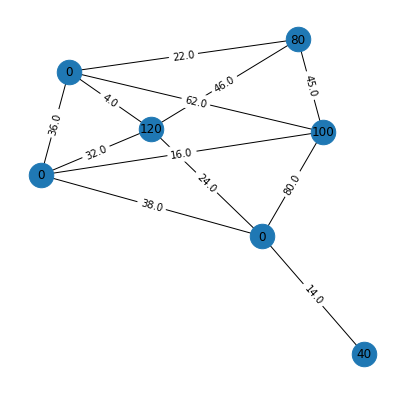

In [77]:
#Grafo da instancia
f, ax = plt.subplots(figsize=(7,7))
pos = nx.spring_layout(g)

nx.draw(
    g,
    nodelist=g.nodes(),
    node_size=600,
    pos=pos,
    labels={node: int(inst.getTerminalPenalties()[node]) for node in g.nodes()}, #nx.get_node_attributes(x, 'prize'),
    ax=ax,
    #node_color=["red" if terminal else "turquoise" for terminal in nx.get_node_attributes(x, 'terminal').values()],
    edgelist=g.edges()
)

edge_labels = nx.draw_networkx_edge_labels(g, pos=pos, edge_labels=nx.get_edge_attributes(g, 'cost'))

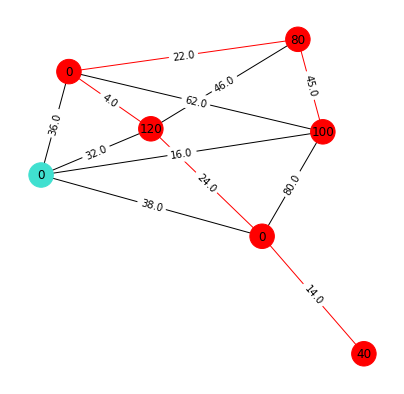

In [78]:
#Solução da HC
f, ax = plt.subplots(figsize=(7,7))

nx.draw(
    x,
    nodelist=g.nodes(),
    node_size=600,
    pos=pos,
    labels={node: int(inst.getTerminalPenalties()[node]) for node in g.nodes()}, #nx.get_node_attributes(x, 'prize'),
    ax=ax,
    node_color=["red" if node in x.nodes() else "turquoise" for node in g.nodes()],
    #node_color=["red" if terminal else "turquoise" for terminal in nx.get_node_attributes(x, 'terminal').values()],
    edgelist=g.edges(),
    edge_color=["red" if edge in x.edges() else "black" for edge in g.edges()]
)

edge_labels = nx.draw_networkx_edge_labels(g, pos=pos, edge_labels=nx.get_edge_attributes(g, 'cost'))

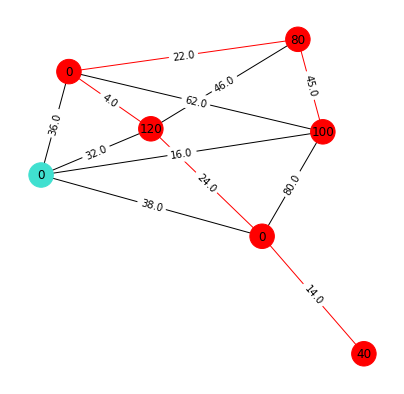

In [79]:
#Solução do problema Steiner Tree pelo networkx
f, ax = plt.subplots(figsize=(7,7))

nx.draw(
    g,
    nodelist=g.nodes(),
    node_size=600,
    pos=pos,
    labels={node: int(inst.getTerminalPenalties()[node]) for node in g.nodes()}, #nx.get_node_attributes(x, 'prize'),
    ax=ax,
    node_color=["red" if node in steiner.nodes() else "turquoise" for node in g.nodes()],
    #node_color=["red" if terminal else "turquoise" for terminal in nx.get_node_attributes(x, 'terminal').values()],
    edgelist=g.edges(),
    edge_color=["red" if edge in steiner.edges() else "black" for edge in g.edges()]
)

edge_labels = nx.draw_networkx_edge_labels(g, pos=pos, edge_labels=nx.get_edge_attributes(g, 'cost'))

#### Instance 2

In [80]:
inst = readInstance("Instances/Toy/inst_2.stp", False)
g = instanceGraph(inst)
x = initialSolution(inst, g, inst.getEdges(), inst.getTerminalPenalties())
c = treeCost(x, inst.getNumNodes(), inst.getEdges(), inst.getTerminalPenalties())
print("HC Cost: ", c)

nodes = [i if prize > 0 else -1 for i, prize in enumerate(inst.getTerminalPenalties())]
nodes = list(filter(lambda node: node > -1, nodes))

steiner = steinertree.steiner_tree(g, nodes, weight='cost')
c = treeCost(steiner, inst.getNumNodes(), inst.getEdges(), inst.getTerminalPenalties())
print("NetworkX Steiner cost: ", c)

HC Cost:  33.0
NetworkX Steiner cost:  39.0


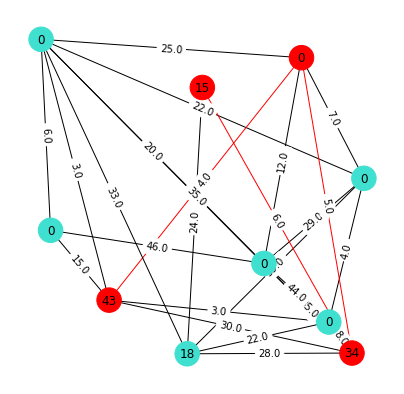

In [81]:
#Solução da HC
f, ax = plt.subplots(figsize=(7,7))
pos = nx.random_layout(g)

nx.draw(
    g,
    nodelist=g.nodes(),
    node_size=600,
    pos=pos,
    labels={node: int(inst.getTerminalPenalties()[node]) for node in g.nodes()}, #nx.get_node_attributes(x, 'prize'),
    ax=ax,
    node_color=["red" if node in x.nodes() else "turquoise" for node in g.nodes()],
    #node_color=["red" if terminal else "turquoise" for terminal in nx.get_node_attributes(x, 'terminal').values()],
    edgelist=g.edges(),
    edge_color=["red" if edge in x.edges() else "black" for edge in g.edges()]
)

edge_labels = nx.draw_networkx_edge_labels(g, pos=pos, edge_labels=nx.get_edge_attributes(g, 'cost'))

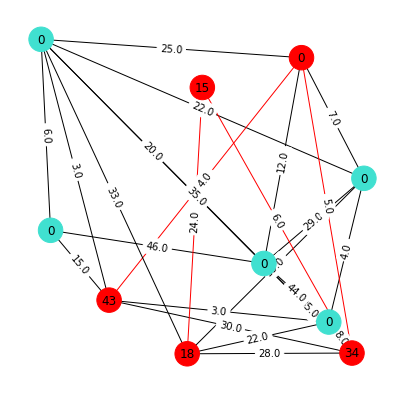

In [82]:
#Solução do problema Steiner Tree pelo networkx
f, ax = plt.subplots(figsize=(7,7))

nx.draw(
    g,
    nodelist=g.nodes(),
    node_size=600,
    pos=pos,
    labels={node: int(inst.getTerminalPenalties()[node]) for node in g.nodes()}, #nx.get_node_attributes(x, 'prize'),
    ax=ax,
    node_color=["red" if node in steiner.nodes() else "turquoise" for node in g.nodes()],
    #node_color=["red" if terminal else "turquoise" for terminal in nx.get_node_attributes(x, 'terminal').values()],
    edgelist=g.edges(),
    edge_color=["red" if edge in steiner.edges() else "black" for edge in g.edges()]
)

edge_labels = nx.draw_networkx_edge_labels(g, pos=pos, edge_labels=nx.get_edge_attributes(g, 'cost'))

#### Instance 3 - 4 - 5

In [83]:
inst = readInstance("Instances/Toy/inst_3.stp", False)
g = instanceGraph(inst)
x = initialSolution(inst, g, inst.getEdges(), inst.getTerminalPenalties())
c = treeCost(x, inst.getNumNodes(), inst.getEdges(), inst.getTerminalPenalties())
print("HC Cost: ", c)

nodes = [i if prize > 0 else -1 for i, prize in enumerate(inst.getTerminalPenalties())]
nodes = list(filter(lambda node: node > -1, nodes))

steiner = steinertree.steiner_tree(g, nodes, weight='cost')
c = treeCost(steiner, inst.getNumNodes(), inst.getEdges(), inst.getTerminalPenalties())
print("NetworkX Steiner cost: ", c)

HC Cost:  145.0
NetworkX Steiner cost:  220.0


In [84]:
inst = readInstance("Instances/Toy/inst_4.stp", False)
g = instanceGraph(inst)
x = initialSolution(inst, g, inst.getEdges(), inst.getTerminalPenalties())
c = treeCost(x, inst.getNumNodes(), inst.getEdges(), inst.getTerminalPenalties())
print("HC Cost: ", c)

nodes = [i if prize > 0 else -1 for i, prize in enumerate(inst.getTerminalPenalties())]
nodes = list(filter(lambda node: node > -1, nodes))

steiner = steinertree.steiner_tree(g, nodes, weight='cost')
c = treeCost(steiner, inst.getNumNodes(), inst.getEdges(), inst.getTerminalPenalties())
print("NetworkX Steiner cost: ", c)

HC Cost:  233.0
NetworkX Steiner cost:  312.0


In [85]:
inst = readInstance("Instances/Toy/inst_5.stp", False)
g = instanceGraph(inst)
x = initialSolution(inst, g, inst.getEdges(), inst.getTerminalPenalties())
c = treeCost(x, inst.getNumNodes(), inst.getEdges(), inst.getTerminalPenalties())
print("HC Cost: ", c)

nodes = [i if prize > 0 else -1 for i, prize in enumerate(inst.getTerminalPenalties())]
nodes = list(filter(lambda node: node > -1, nodes))

steiner = steinertree.steiner_tree(g, nodes, weight='cost')
c = treeCost(steiner, inst.getNumNodes(), inst.getEdges(), inst.getTerminalPenalties())
print("NetworkX Steiner cost: ", c)

HC Cost:  348.0
NetworkX Steiner cost:  439.0


#### Instancias dos outros grupos - planilha compartilhada

In [86]:
folder = "Instances/Toy/Other Groups/"
directory = os.fsencode(folder)
for file in os.listdir(directory):
    filename = file.decode("utf-8")
    if '.stp' not in filename:
        continue

    print(filename)

    inst = readInstance(folder + filename, False)
    g = instanceGraph(inst)
    x = initialSolution(inst, g, inst.getEdges(), inst.getTerminalPenalties())
    c = treeCost(x, inst.getNumNodes(), inst.getEdges(), inst.getTerminalPenalties())
    print("HC Cost: ", c)

    nodes = [i if prize > 0 else -1 for i, prize in enumerate(inst.getTerminalPenalties())]
    nodes = list(filter(lambda node: node > -1, nodes))

    steiner = steinertree.steiner_tree(g, nodes, weight='cost')
    c = treeCost(steiner, inst.getNumNodes(), inst.getEdges(), inst.getTerminalPenalties())
    print("NetworkX Steiner cost: ", c, "\n")

aco1.stp
HC Cost:  17.0
NetworkX Steiner cost:  17.0 

aco2.stp
HC Cost:  12.0
NetworkX Steiner cost:  12.0 

aco3.stp
HC Cost:  5.0
NetworkX Steiner cost:  5.0 

aco4.stp
HC Cost:  60.0
NetworkX Steiner cost:  60.0 

aco5.stp
HC Cost:  6.0
NetworkX Steiner cost:  6.0 

bt1.stp
HC Cost:  18.0
NetworkX Steiner cost:  18.0 

bt3.stp
HC Cost:  6.0
NetworkX Steiner cost:  6.0 

bt5.stp
HC Cost:  32.0
NetworkX Steiner cost:  32.0 

bt7.stp
HC Cost:  30.0
NetworkX Steiner cost:  30.0 



### Testes

In [87]:
inst = readInstance("Instances/CRR-D/D01-A.stp", True)
g = instanceGraph(inst)
x = initialSolution(inst, g, inst.getEdges(), inst.getTerminalPenalties())
c = treeCost(x, inst.getNumNodes(), inst.getEdges(), inst.getTerminalPenalties())
print("HC Cost: ", c)

nodes = [i if prize > 0 else -1 for i, prize in enumerate(inst.getTerminalPenalties())]
nodes = list(filter(lambda node: node > -1, nodes))

steiner = steinertree.steiner_tree(g, nodes, weight='cost')
steinerCost = treeCost(steiner, inst.getNumNodes(), inst.getEdges(), inst.getTerminalPenalties())
print("NetworkX Steiner cost: ", steinerCost)

HC Cost:  44.0
NetworkX Steiner cost:  107.0


In [88]:
graspG, graspCost, grasp_info = GRASP(g, inst, 0.2, 20)
grasp_info

{'nodes': 1000,
 'edges': 1250,
 'terminals': 5,
 'HC_time': 0.0009999275207519531,
 'HC': 44.0,
 'LS': 27.0,
 'LS_time': 0.05079221725463867,
 'GRASP': 27.0,
 'GRASP_time': 0.0757136344909668,
 'GRASP_iterations': 21,
 'Initial_solutions': 1}

In [89]:
graspG, graspCost, grasp_info = GRASP(g, inst, 0.2, 20, 0.1)
grasp_info

{'nodes': 1000,
 'edges': 1250,
 'terminals': 5,
 'HC_time': 0.0009958744049072266,
 'HC': 44.0,
 'LS': 27.0,
 'LS_time': 0.035965681076049805,
 'GRASP': 27.0,
 'GRASP_time': 19.80878496170044,
 'GRASP_iterations': 21,
 'Initial_solutions': 21}

In [90]:
graspG, graspCost, grasp_info = GRASP(g, inst, 0.2, 20, 0.1, 10)
grasp_info

{'nodes': 1000,
 'edges': 1250,
 'terminals': 5,
 'HC_time': 0.0021209716796875,
 'HC': 44.0,
 'LS': 27.0,
 'LS_time': 0.12417912483215332,
 'GRASP': 27.0,
 'GRASP_time': 19.742819786071777,
 'GRASP_iterations': 21,
 'Initial_solutions': 21}

In [96]:
inst = readInstance("Instances/CRR-C/C03-A.stp", True)
g = instanceGraph(inst)
print(nx.info(g))

x = initialSolution(inst, g, inst.getEdges(), inst.getTerminalPenalties())
c = treeCost(x, inst.getNumNodes(), inst.getEdges(), inst.getTerminalPenalties())
print("HC Cost: ", c)

nodes = [i if prize > 0 else -1 for i, prize in enumerate(inst.getTerminalPenalties())]
nodes = list(filter(lambda node: node > -1, nodes))

steiner = steinertree.steiner_tree(g, nodes, weight='cost')
steinerCost = treeCost(steiner, inst.getNumNodes(), inst.getEdges(), inst.getTerminalPenalties())
print("NetworkX Steiner cost: ", steinerCost)

Graph with 500 nodes and 625 edges
HC Cost:  649.0
NetworkX Steiner cost:  779.0


In [98]:
graspG, graspCost, grasp_info = GRASP(g, inst, 0.2, 20)
grasp_info

{'nodes': 500,
 'edges': 625,
 'terminals': 83,
 'HC_time': 0.028136253356933594,
 'HC': 649.0,
 'LS': 462.0,
 'LS_time': 1.337244987487793,
 'GRASP': 419.0,
 'GRASP_time': 115.37631392478943,
 'GRASP_iterations': 83,
 'Initial_solutions': 73}

In [99]:
graspG, graspCost, grasp_info = GRASP(g, inst, 0.2, 20, 0.1)
grasp_info

{'nodes': 500,
 'edges': 625,
 'terminals': 83,
 'HC_time': 0.045114994049072266,
 'HC': 649.0,
 'LS': 449.0,
 'LS_time': 2.937656879425049,
 'GRASP': 425.0,
 'GRASP_time': 75.22460150718689,
 'GRASP_iterations': 33,
 'Initial_solutions': 33}

In [97]:
graspG, graspCost, grasp_info = GRASP(g, inst, 0.2, 20, 0.1, 10)
grasp_info

{'nodes': 500,
 'edges': 625,
 'terminals': 83,
 'HC_time': 0.03281974792480469,
 'HC': 649.0,
 'LS': 443.0,
 'LS_time': 1.7042045593261719,
 'GRASP': 433.0,
 'GRASP_time': 69.02876496315002,
 'PR': 419.0,
 'PR_time': 11.582231521606445,
 'GRASP_iterations': 28,
 'Initial_solutions': 28}

### Testes das instancias de Benchmark

folder = "Instances/CRR-D/"
files = ['D01-A.stp', 'D03-A.stp', 'D06-A.stp', 'D08-A.stp', 'D13-A.stp', 'D18-A.stp']
f = open(f'Instances/result-D.txt', "w")
directory = os.fsencode(folder)
for file in os.listdir(directory):
    filename = file.decode("utf-8")
    if filename not in files:
        continue

    inst = readInstance(folder + filename, True)
    g = instanceGraph(inst)

    for i in []: #range(5):
        graspG, graspCost, instance_info = GRASP(g, inst, 0.2, 20, 0.1, 10)
        instance_info['instance'] = filename
        instance_info['execution'] = i
        f.write(json.dumps(instance_info))
        f.write("\n")

f.close()

folder = "Instances/CRR-C/"
files = ['C01-A.stp', 'C03-A.stp', 'C04-A.stp', 'C06-A.stp', 'C08-A.stp', 'C13-A.stp', 'C18-A.stp', 'C19-A.stp']
f = open(f'Instances/result-C.txt', "w")
directory = os.fsencode(folder)
for file in os.listdir(directory):
    filename = file.decode("utf-8")
    if filename not in files:
        continue

    inst = readInstance(folder + filename, True)
    g = instanceGraph(inst)

    for i in []: #range(5):
        graspG, graspCost, instance_info = GRASP(g, inst, 0.2, 20, 0.1, 10)
        instance_info['instance'] = filename
        instance_info['execution'] = i
        f.write(json.dumps(instance_info))
        f.write("\n")

f.close()

folder = "Instances/i640/"
files = ['i640-001.stp', 'i640-014.stp', 'i640-023.stp', 'i640-034.stp', 'i640-045.stp', 'i640-102.stp', 'i640-114.stp', 
         'i640-124.stp', 'i640-133.stp', 'i640-142.stp', 'i640-201.stp', 'i640-212.stp', 'i640-223.stp', 'i640-233.stp', 'i640-243.stp']
f = open(f'Instances/result-i640.txt', "w")
start = time.time()
directory = os.fsencode(folder)
for file in os.listdir(directory):
    filename = file.decode("utf-8")
    if filename not in files:
        continue
    
    print(filename, '->', time.time() - start)
    inst = readInstance(folder + filename, True)
    g = instanceGraph(inst)

    for i in []: #range(5):
        graspG, graspCost, instance_info = GRASP(g, inst, 0.2, 20, 0.1, 10)
        instance_info['instance'] = filename
        instance_info['execution'] = i
        f.write(json.dumps(instance_info))
        f.write("\n")

f.close()

folder = "Instances/H/"
files = ['hc6p.stp', 'hc7p.stp', 'hc8p.stp', 'hc9p.stp']
f = open(f'Instances/result-H.txt', "w")
start = time.time()
directory = os.fsencode(folder)
for file in os.listdir(directory):
    filename = file.decode("utf-8")
    if filename not in files:
        continue
    
    print(filename, '->', time.time() - start)
    inst = readInstance(folder + filename, True)
    g = instanceGraph(inst)

    for i in []: #range(5):
        graspG, graspCost, instance_info = GRASP(g, inst, 0.2, 20, 0.1, 10)
        instance_info['instance'] = filename
        instance_info['execution'] = i
        f.write(json.dumps(instance_info))
        f.write("\n")

f.close()

folder = "Instances/H2/"
files = ['hc6p2.stp', 'hc7p2.stp', 'hc8p2.stp', 'hc9p2.stp']
f = open(f'Instances/result-H2.txt', "w")
start = time.time()
directory = os.fsencode(folder)
for file in os.listdir(directory):
    filename = file.decode("utf-8")
    if filename not in files:
        continue
    
    print(filename, '->', time.time() - start)
    inst = readInstance(folder + filename, True)
    g = instanceGraph(inst)

    for i in []: #range(5):
        graspG, graspCost, instance_info = GRASP(g, inst, 0.2, 20, 0.1, 10)
        instance_info['instance'] = filename
        instance_info['execution'] = i
        f.write(json.dumps(instance_info))
        f.write("\n")

f.close()

folder = "Instances/PUCNU/"
files = ['bipe2nu.stp', 'bip42nu.stp', 'bip62nu.stp', 'cc3-4nu.stp', 'cc3-5nu.stp', 'cc5-3nu.stp', 'cc6-2nu.stp', 'cc6-3nu.stp', 'cc9-2nu.stp', 'cc3-10nu.stp', 'cc10-2nu.stp']
f = open(f'Instances/result-PUCNU.txt', "w")
start = time.time()
directory = os.fsencode(folder)
for file in os.listdir(directory):
    filename = file.decode("utf-8")
    if filename not in files:
        continue
    
    print(filename, '->', time.time() - start)
    inst = readInstance(folder + filename, True)
    g = instanceGraph(inst)

    for i in []: #range(5):
        graspG, graspCost, instance_info = GRASP(g, inst, 0.2, 20, 0.1, 10)
        instance_info['instance'] = filename
        instance_info['execution'] = i
        f.write(json.dumps(instance_info))
        f.write("\n")

f.close()

### Organização dos resultados em dataframe

In [101]:
lb_articles_reference = {
    'D01-A.stp':18,
    'D03-A.stp':807,
    'D06-A.stp':18,
    'D08-A.stp':755,
    'D13-A.stp':445,
    'D18-A.stp':218,
    'bipe2nu.stp':57, 
    'bip42nu.stp':280, 
    'bip62nu.stp':254, 
    'cc3-4nu.stp':11, 
    'cc3-5nu.stp':19, 
    'cc5-3nu.stp':38, 
    'cc6-2nu.stp':15, 
    'cc6-3nu.stp':104, 
    'cc9-2nu.stp':90, 
    'cc3-10nu.stp':65, 
    'cc10-2nu.stp':188,
    'hc6p2.stp':4468, 
    'hc7p2.stp':9163, 
    'hc8p2.stp':18915, 
    'hc9p2.stp':37379,
    'hc6p.stp':4483, 
    'hc7p.stp':9108, 
    'hc8p.stp':18452, 
    'hc9p.stp':35759,
    'C01-A.stp':18, 
    'C03-A.stp':414, 
    'C04-A.stp':618, 
    'C06-A.stp':18, 
    'C08-A.stp':361, 
    'C13-A.stp':236, 
    'C18-A.stp':111, 
    'C19-A.stp':146,
    'i640-001.stp':3414, 
    'i640-014.stp':2667, 
    'i640-023.stp':2072, 
    'i640-034.stp':3188, 
    'i640-045.stp':1932, 
    'i640-102.stp':8575, 
    'i640-114.stp':7271,
    'i640-124.stp':6317, 
    'i640-133.stp':8253, 
    'i640-142.stp':6239, 
    'i640-201.stp':15953, 
    'i640-212.stp':14377, 
    'i640-223.stp':13065, 
    'i640-233.stp':15172, 
    'i640-243.stp':12843,
    'i640-302.stp':48225, 
    'i640-315.stp':43114, 
    'i640-325.stp':40249, 
    'i640-333.stp':48135, 
    'i640-342.stp':41940
}

In [102]:
json_data = []

for filename in ['result-C.txt', 'result-D.txt', 'result-H.txt', 'result-H2.txt', 'result-i640.txt', 'result-PUCNU.txt']:
    file = open('Instances/' + filename)
    data = file.read()
    lines = data.split("\n")

    for line in lines:
        if line != "":
            data = json.loads(line)
            data['Class'] = filename[7:-4]
            json_data.append(data)

df = pd.json_normalize(json_data)

In [103]:
df2 = df[['Class','instance','execution','nodes','edges', 'terminals', 'HC', 'LS', 'GRASP', 'PR', 'GRASP_iterations', 'Initial_solutions', 'HC_time', 'LS_time', 'GRASP_time', 'PR_time']]
df2["Total time"] = df2[["HC_time", "LS_time", "GRASP_time", "PR_time"]].sum(axis=1)
df2 = df2.round({'Total time':3, 'HC_time':3, 'LS_time':3, 'GRASP_time':3, 'PR_time':3})

C:\Users\simoe\AppData\Local\Temp/ipykernel_15864/2449317416.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["Total time"] = df2[["HC_time", "LS_time", "GRASP_time", "PR_time"]].sum(axis=1)


In [104]:
df2.head()

,Class,instance,execution,nodes,edges,terminals,HC,LS,GRASP,PR,GRASP_iterations,Initial_solutions,HC_time,LS_time,GRASP_time,PR_time,Total time
0,C,C01-A.stp,0,500,625,5,62.0,27.0,27.0,NaN,21,21,0.001,0.033,9.858,NaN,9.892
1,C,C01-A.stp,1,500,625,5,62.0,27.0,27.0,NaN,21,21,0.001,0.131,9.624,NaN,9.755
2,C,C01-A.stp,2,500,625,5,62.0,27.0,27.0,NaN,21,21,0.001,0.065,8.925,NaN,8.991
3,C,C01-A.stp,3,500,625,5,62.0,27.0,27.0,NaN,21,21,0.000,0.192,10.051,NaN,10.243
4,C,C01-A.stp,4,500,625,5,62.0,27.0,27.0,NaN,21,21,0.001,0.201,10.897,NaN,11.099


In [105]:
instances_json = []
instances = df2['instance'].unique()
df2['solution'] = df2[["GRASP", "PR"]].min(axis = 1)
for instance in instances:
    execs = df2.loc[df2['instance'] == instance]
    execs.reset_index(drop=True, inplace=True)
    inst_data = {
        'class': execs['Class'][0],
        'instance': instance,
        'nodes': execs['nodes'][0],
        'edges': execs['edges'][0],
        'terminals': execs['terminals'][0],
        'HC': execs['HC'][0],
        'LS_mean': execs['LS'].mean(),
        'LS_best': execs['LS'].min(),
        'GRASP_mean': execs['GRASP'].mean(),
        'GRASP_best': execs['GRASP'].min(),
        'PR_mean': execs['PR'].mean(),
        'Cost_best': execs['solution'].min(),
        'Cost_mean': execs['solution'].mean(),
        'Cost_std': execs['solution'].std(),
        'Optimal': lb_articles_reference[instance],
        'Time': execs['Total time'].mean()
    }

    instances_json.append(inst_data)

new_df = pd.json_normalize(instances_json)
new_df.head()

,class,instance,nodes,edges,terminals,HC,LS_mean,LS_best,GRASP_mean,GRASP_best,PR_mean,Cost_best,Cost_mean,Cost_std,Optimal,Time
0,C,C01-A.stp,500,625,5,62.0,27.0,27.0,27.0,27.0,NaN,27.0,27.0,0.000000,18,9.9960
1,C,C03-A.stp,500,625,83,649.0,450.8,444.0,425.0,419.0,422.2,419.0,422.2,4.381780,414,176.6976
2,C,C04-A.stp,500,625,125,808.0,639.4,635.0,631.0,629.0,630.8,629.0,630.8,1.643168,618,216.2774
3,C,C06-A.stp,500,1000,5,52.0,27.0,27.0,27.0,27.0,NaN,27.0,27.0,0.000000,18,7.5642
4,C,C08-A.stp,500,1000,83,449.0,375.0,370.0,364.4,362.0,361.6,361.0,361.6,0.547723,361,174.5736


In [106]:
new_df['GAP_HC'] = 100 * (new_df['HC'] - new_df['Optimal']) / new_df['Optimal']
new_df['GAP_LS'] = 100 * (new_df['LS_mean'] - new_df['Optimal']) / new_df['Optimal']
new_df['GAP_GRASP'] = 100 * (new_df['GRASP_mean'] - new_df['Optimal']) / new_df['Optimal']
new_df['GAP_PR'] = 100 * (new_df['Cost_best'] - new_df['Optimal']) / new_df['Optimal']

In [107]:
new_df['GAP_HC'][new_df['GAP_HC'] < 0] = 0
new_df['GAP_LS'][new_df['GAP_LS'] < 0] = 0
new_df['GAP_GRASP'][new_df['GAP_GRASP'] < 0] = 0
new_df['GAP_PR'][new_df['GAP_PR'] < 0] = 0

C:\Users\simoe\AppData\Local\Temp/ipykernel_15864/3164757299.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['GAP_HC'][new_df['GAP_HC'] < 0] = 0
C:\Users\simoe\AppData\Local\Temp/ipykernel_15864/3164757299.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['GAP_LS'][new_df['GAP_LS'] < 0] = 0
C:\Users\simoe\AppData\Local\Temp/ipykernel_15864/3164757299.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['GAP_GR

In [108]:
new_df.head()

,class,instance,nodes,edges,terminals,HC,LS_mean,LS_best,GRASP_mean,GRASP_best,PR_mean,Cost_best,Cost_mean,Cost_std,Optimal,Time,GAP_HC,GAP_LS,GAP_GRASP,GAP_PR
0,C,C01-A.stp,500,625,5,62.0,27.0,27.0,27.0,27.0,NaN,27.0,27.0,0.000000,18,9.9960,244.444444,50.000000,50.000000,50.000000
1,C,C03-A.stp,500,625,83,649.0,450.8,444.0,425.0,419.0,422.2,419.0,422.2,4.381780,414,176.6976,56.763285,8.888889,2.657005,1.207729
2,C,C04-A.stp,500,625,125,808.0,639.4,635.0,631.0,629.0,630.8,629.0,630.8,1.643168,618,216.2774,30.744337,3.462783,2.103560,1.779935
3,C,C06-A.stp,500,1000,5,52.0,27.0,27.0,27.0,27.0,NaN,27.0,27.0,0.000000,18,7.5642,188.888889,50.000000,50.000000,50.000000
4,C,C08-A.stp,500,1000,83,449.0,375.0,370.0,364.4,362.0,361.6,361.0,361.6,0.547723,361,174.5736,24.376731,3.878116,0.941828,0.000000


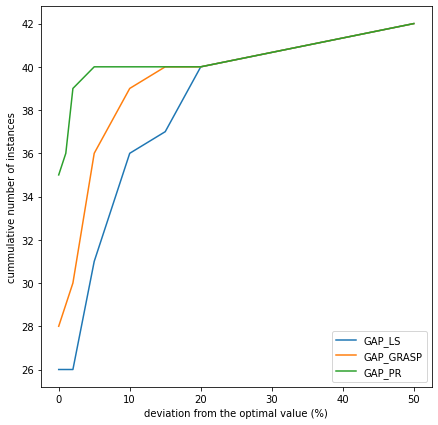

In [109]:
fig, ax = plt.subplots(figsize=(7,7))

im_df = new_df
for gap in ['GAP_LS', 'GAP_GRASP', 'GAP_PR']:
    max_gap = im_df[gap].max()
    cummulative_instances_deviation = []
    for i in [0, 1, 2, 5, 10, 15, 20]:
        cummulative_instances_deviation.append((i, (im_df[gap] <= i).sum()))
    cummulative_instances_deviation.append((max_gap, (im_df[gap] <= max_gap).sum()))

    deviation = [i for i, j in cummulative_instances_deviation]
    intances_count = [j for i, j in cummulative_instances_deviation]
    ax.plot(deviation, intances_count, label=gap)

ax.set_xlabel('deviation from the optimal value (%)')
ax.set_ylabel('cummulative number of instances')
plt.legend(loc='lower right')


In [110]:
instances_json = []
instances = new_df['class'].unique()
for instance in instances:
    execs = new_df.loc[new_df['class'] == instance]
    execs.reset_index(drop=True, inplace=True)
    inst_data = {
        'class': execs['class'][0],
        'instances': len(execs),
        'optimal': (execs['GAP_PR'] <= 0).sum(),
        '< 1%': (execs['GAP_PR'] < 1).sum(),
        '< 2%': (execs['GAP_PR'] < 2).sum(),
        '< 5%': (execs['GAP_PR'] < 5).sum(),
        'Time': execs['Time'].mean()
    }

    instances_json.append(inst_data)

final_df = pd.json_normalize(instances_json)
final_df = final_df.round({'Time':2})
print(final_df.to_string(index=False))
#print(final_df.to_latex(index=False))

class  instances  optimal  < 1%  < 2%  < 5%    Time
    C          8        1     2     5     6  181.41
    H          4        4     4     4     4 1731.35
   H2          4        4     4     4     4 1492.94
 i640         15       15    15    15    15  167.30
PUCNU         11       11    11    11    11  629.93


In [111]:
d_df = new_df.loc[[8,10,9,11,12,13]][['instance', 'terminals', 'GAP_GRASP', 'GAP_PR', 'Time']]
d_df = d_df.round({'GAP_GRASP':2, 'GAP_PR':2, 'Time':1})
print(d_df.to_string(index=False))
#print(d_df.to_latex(index=False))

 instance  terminals  GAP_GRASP  GAP_PR   Time
 hc6p.stp         64        0.0     0.0   19.4
 hc8p.stp        256        0.0     0.0  711.4
 hc7p.stp        128        0.0     0.0   83.7
 hc9p.stp        512        0.0     0.0 6110.8
hc6p2.stp         64        0.0     0.0   12.1
hc7p2.stp        128        0.0     0.0   72.5
